# Clasificación

In [3]:
from typing import Any, List, Tuple, Union, Dict
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from io import StringIO
from IPython.display import HTML, display


def print_tabulate(df: pd.DataFrame) -> None:
    """
    Imprime un DataFrame en formato de tabla.
    
    :param df: DataFrame a imprimir
    """
    display(HTML(tabulate(df, headers=df.columns, tablefmt="html")))

def transform_variable(df: pd.DataFrame, x: str) -> pd.DataFrame:
    """
    Transforma una variable categórica en numérica.
    
    :param df: DataFrame que contiene la variable
    :param x: Nombre de la columna a transformar
    :return: Serie con la variable transformada
    """
    return df[x] if pd.api.types.is_numeric_dtype(df[x]) else pd.DataFrame({x: [i for i in range(0, len(df[x]))]})

def split_train_test(df: pd.DataFrame, x_label: str, y_label: str, test_size: float = 0.3, random_state: int = 0) -> Tuple:
    """
    Divide los datos en conjuntos de entrenamiento y prueba para regresión.
    
    :param df: DataFrame con los datos
    :param x_label: Nombre de la columna de características
    :param y_label: Nombre de la columna objetivo
    :param test_size: Proporción del conjunto de prueba
    :param random_state: Semilla para reproducibilidad
    :return: Tupla con los conjuntos de entrenamiento y prueba
    """
    fixed_x = transform_variable(df, x_label)
    return train_test_split(fixed_x, df[y_label], test_size=test_size, random_state=random_state)

def split_train_test_classification(df: pd.DataFrame, x_labels: List[str], y_label: str, test_size: float = 0.3, random_state: int = 0) -> Tuple:
    """
    Divide los datos en conjuntos de entrenamiento y prueba para clasificación.
    
    :param df: DataFrame con los datos
    :param x_labels: Lista de nombres de columnas de características
    :param y_label: Nombre de la columna objetivo
    :param test_size: Proporción del conjunto de prueba
    :param random_state: Semilla para reproducibilidad
    :return: Tupla con los conjuntos de entrenamiento y prueba
    """
    return train_test_split(df[x_labels], df[y_label], test_size=test_size, random_state=random_state)

def train_model(x, y, model_class: Union[type[KNeighborsClassifier], type[LogisticRegression], type[SVC]], model_params: Dict[str, Any] = None) -> Union[KNeighborsClassifier, LogisticRegression, SVC]:
    """
    Entrena un modelo de clasificación.
    
    :param x: Características de entrenamiento
    :param y: Etiquetas de entrenamiento
    :param model_class: Clase del modelo a entrenar
    :param model_params: Parámetros del modelo
    :return: Modelo entrenado
    """
    print(f"Usando {model_class.__name__} con {model_params}")
    model = model_class() if not model_params else model_class(**model_params)
    return model.fit(x, y)

def create_plot(subplots: int = 111) -> Tuple[plt.Figure, plt.Axes]:
    """
    Crea una figura y ejes para graficar.
    
    :param subplots: Configuración de subplots
    :return: Tupla con la figura y los ejes
    """
    fig = plt.figure()
    ax = fig.add_subplot(subplots)
    return fig, ax

def plot_points(ax: plt.Axes, x, y, scatter_params: Dict[str, Any]) -> None:
    """
    Grafica puntos en un eje.
    
    :param ax: Eje donde graficar
    :param x: Valores x
    :param y: Valores y
    :param scatter_params: Parámetros para scatter
    """
    ax.scatter(x, y, **scatter_params)

def plot_line(ax: plt.Axes, x, y, color: str, label: str = 'line') -> None:
    """
    Grafica una línea en un eje.
    
    :param ax: Eje donde graficar
    :param x: Valores x
    :param y: Valores y
    :param color: Color de la línea
    :param label: Etiqueta de la línea
    """
    ax.plot(x, y, color=color, label=label)

def finalize_and_save(fig: plt.Figure, ax: plt.Axes, file_name: str, ylim: Tuple[float, float] = None, rotation: int = 90, size_inches: Tuple[int, int] = (27, 18)) -> None:
    """
    Finaliza y guarda una gráfica.
    
    :param fig: Figura a guardar
    :param ax: Eje a ajustar
    :param file_name: Nombre del archivo para guardar
    :param ylim: Límites del eje y
    :param rotation: Rotación de las etiquetas del eje x
    :param size_inches: Tamaño de la figura en pulgadas
    """
    ax.tick_params(axis='x', labelrotation=rotation)
    fig.set_size_inches(*size_inches)
    if ylim:
        ax.set_ylim(ylim)
    fig.savefig(file_name)
    plt.show()
    plt.close()

def prepare_file() -> pd.DataFrame:
    """
    Prepara y agrupa los datos del archivo CSV.
    
    :return: DataFrame agrupado
    """
    df = pd.read_csv("../csv/typed_uanl.csv")
    df_by_sal = df.groupby(["Tipo", "Fecha"])["Sueldo Neto"].agg(['sum', 'count', 'mean']).reset_index()
    df_by_sal.columns = ['Tipo', 'Fecha', 'sueldo_neto_sum', 'conteo_empleados', 'promedio_pago']
    return df_by_sal

def detect_outlier(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    """
    Detecta valores atípicos usando regresión lineal.
    
    :param df: DataFrame con los datos
    :param x: Nombre de la columna de características
    :param y: Nombre de la columna objetivo
    :return: DataFrame con una columna adicional de outliers
    """
    fixed_x = transform_variable(df, x)

    model = sm.OLS(df[y], sm.add_constant(fixed_x)).fit()
    bands = pd.read_html(
        StringIO(model.summary().tables[1].as_html()), 
        header=0, 
        index_col=0
    )[0]
    coef = bands['coef']
    lr_dict = {'m': coef.values[1], 'b': coef.values[0], 'low_band': bands['[0.025'].iloc[0], 'hi_band': bands['0.975]'].iloc[0]}
    
    def outlier_dist(y: float, x: float, lr_dict: Dict[str, float]) -> int:
        return int(y > (lr_dict['m'] * x + lr_dict['hi_band']) or y < (lr_dict['m'] * x + lr_dict['low_band']))
    
    outliers = [outlier_dist(row[y], row[x], lr_dict) for _, row in fixed_x.join(df[y]).iterrows()]
    return df.assign(outliers=outliers)

def prepare_reg_file() -> pd.DataFrame:
    """
    Prepara y agrupa los datos del archivo CSV para regresión.
    
    :return: DataFrame agrupado
    """
    df = pd.read_csv("../csv/typed_uanl.csv")
    df_by_sal = df.groupby("Fecha")["Sueldo Neto"].sum().reset_index()
    df_by_sal.columns = ['Fecha', 'sueldo_neto_sum']
    return df_by_sal.reset_index()

# KNN (k-nearest neighbors algorithm) - k vecinos más próximos
---

## Clasificación KNN - Predicción para nuevos valores

In [4]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.neighbors import KNeighborsClassifier

def train_predict_knn_classifier(df: pd.DataFrame, x: List[str], y: str, df_predict: pd.DataFrame, n_neighbors: int) -> None:
    """
    Crea y visualiza un modelo de clasificación KNN.

    :param df: DataFrame con los datos de entrenamiento
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    :param df_predict: DataFrame con datos para predecir
    :param n_neighbors: Número de vecinos para el modelo KNN
    """
    # Entrenar el modelo
    features = df[x]
    trained_model = train_model(features, df[y], KNeighborsClassifier, {'n_neighbors': n_neighbors})
    
    # Realizar predicciones
    df_predict[y] = trained_model.predict(df_predict[x])

    # Crear la gráfica
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        filter_df = df[df[y] == class_]
        filter_predict_df = df_predict[df_predict[y] == class_]
        
        # Graficar puntos de entrenamiento
        plot_points(ax, filter_df[x[0]], filter_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (train)"})
        
        # Graficar puntos de predicción si existen
        if not filter_predict_df.empty:
            plot_points(ax, filter_predict_df[x[0]], filter_predict_df[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (predict)"})

    # Configurar la gráfica
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title("Clasificador KNN")

    # Guardar la gráfica
    finalize_and_save(fig, ax, f'../img/clasificacion/knn/knn_classifier_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

Usando KNeighborsClassifier con {'n_neighbors': 5}


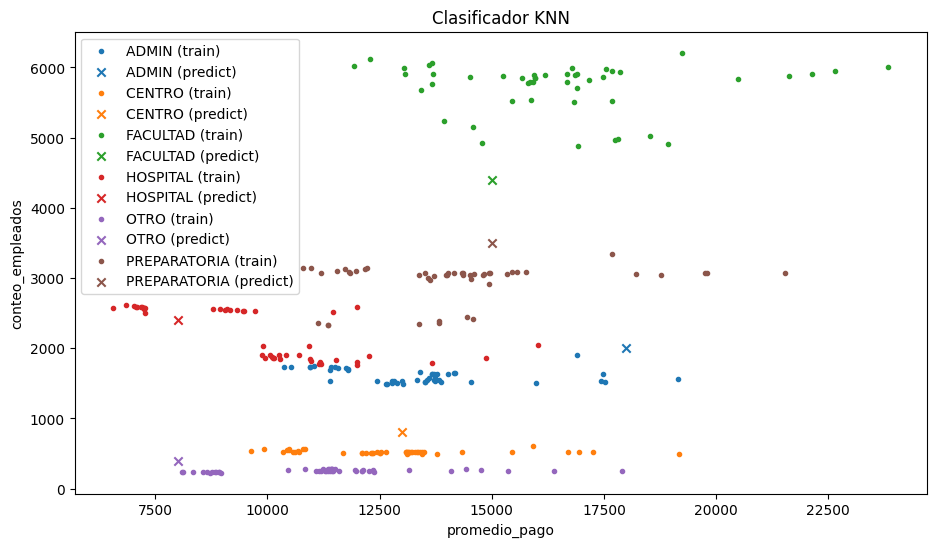

In [5]:
# Preparar los datos
df = prepare_file()
df_predict = pd.DataFrame([
    {"promedio_pago": 8000, "conteo_empleados": 2400},
    {"promedio_pago": 8000, "conteo_empleados": 400},
    {"promedio_pago": 13000, "conteo_empleados": 800},
    {"promedio_pago": 15000, "conteo_empleados": 3500},
    {"promedio_pago": 15000, "conteo_empleados": 4400},
    {"promedio_pago": 18000, "conteo_empleados": 2000}
])

# Ejecutar el modelo
train_predict_knn_classifier(df, ["promedio_pago", "conteo_empleados"], "Tipo", df_predict, 5)

## Clasificación KNN - Evaluación del desempeño

In [88]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.neighbors import KNeighborsClassifier

def train_evaluate_knn_classifier(df: pd.DataFrame, x: List[str], y: str, n_neighbors: int, test_size: float = 0.3) -> None:
    """
    Crea, entrena y evalúa un modelo de clasificación KNN, visualizando los resultados.

    :param df: DataFrame con los datos
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    :param n_neighbors: Número de vecinos para el modelo KNN
    :param test_size: Proporción de datos para el conjunto de prueba
    """
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test_classification(df, x, y, test_size=test_size, random_state=0)

    # Entrenar el modelo
    trained_model = train_model(X_train, y_train, KNeighborsClassifier, {'n_neighbors': n_neighbors})

    # Evaluar el modelo
    score_train = trained_model.score(X_train, y_train)
    score_test = trained_model.score(X_test, y_test)
    predict = trained_model.predict(X_test)

    print(f"Puntuaciones: [entrenamiento {score_train:.4f}, prueba {score_test:.4f}]")

    # Crear la gráfica
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        # Filtrar datos de entrenamiento y prueba
        filter_train_df = X_train[y_train == class_]
        filter_test_df_correct = X_test[(y_test == class_) & (predict == class_)]
        filter_test_df_failure = X_test[(y_test != class_) & (predict == class_)]

        # Graficar puntos de entrenamiento
        plot_points(ax, filter_train_df[x[0]], filter_train_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (train)"})

        # Graficar predicciones correctas
        if not filter_test_df_correct.empty:
            plot_points(ax, filter_test_df_correct[x[0]], filter_test_df_correct[x[1]], 
                        scatter_params={'marker': 'v', 'c': f"C{index}", 'label': f"{class_} (correct)"})

        # Graficar predicciones incorrectas
        if not filter_test_df_failure.empty:
            plot_points(ax, filter_test_df_failure[x[0]], filter_test_df_failure[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (incorrect)"})

    # Configurar la gráfica
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title(f"Clasificador KNN - Puntuaciones: [entrenamiento {score_train:.4f}, prueba {score_test:.4f}]")

    # Guardar la gráfica
    finalize_and_save(fig, ax, f'../img/clasificacion/knn/knn_classifier_model_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

Usando KNeighborsClassifier con {'n_neighbors': 5}
Puntuaciones: [entrenamiento 0.8955, prueba 0.9080]


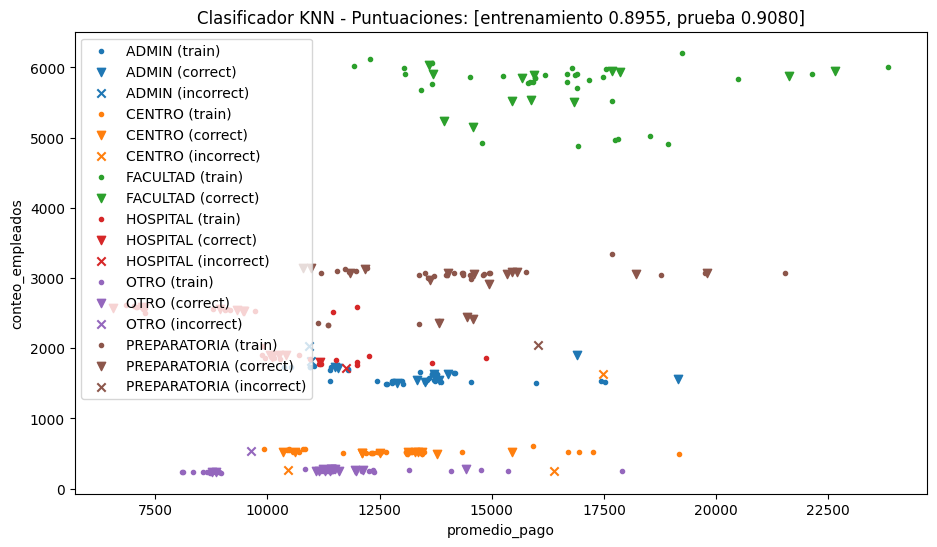

In [89]:
# Preparar los datos y ejecutar el modelo
df = prepare_file()
train_evaluate_knn_classifier(df, ["promedio_pago", "conteo_empleados"], "Tipo", 5, 0.3)

# Logistic Regression - Regresión lógistica
---

## Clasificación lógistica - Evaluación de desempeño

In [90]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.linear_model import LogisticRegression

def train_evaluate_logistic_regression_classifier(df: pd.DataFrame, x: List[str], y: str) -> None:
    """
    Crea, entrena y evalúa un modelo de regresión logística, visualizando los resultados.

    :param df: DataFrame con los datos
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    """
    # Preparar los datos
    df_fixed = df.copy()
    df_fixed['Fecha'] = transform_variable(df, "Fecha")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test_classification(df_fixed, x, y, test_size=0.3, random_state=0)

    # Entrenar el modelo
    trained_model = train_model(X_train, y_train, LogisticRegression, {'random_state': 0, 'C': 1})

    # Evaluar el modelo
    score_train = trained_model.score(X_train, y_train)
    score_test = trained_model.score(X_test, y_test)
    predict_test = trained_model.predict(X_test)

    # Crear la gráfica
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        # Filtrar datos de entrenamiento y prueba
        filter_train_df = X_train[y_train == class_]
        filter_test_df_correct = X_test[(y_test == class_) & (predict_test == class_)]
        filter_test_df_failure = X_test[(y_test != class_) & (predict_test == class_)]

        # Graficar puntos de entrenamiento
        plot_points(ax, filter_train_df[x[0]], filter_train_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (entrenamiento)"})

        # Graficar predicciones correctas
        if not filter_test_df_correct.empty:
            plot_points(ax, filter_test_df_correct[x[0]], filter_test_df_correct[x[1]], 
                        scatter_params={'marker': 'v', 'c': f"C{index}", 'label': f"{class_} (correcto)"})

        # Graficar predicciones incorrectas
        if not filter_test_df_failure.empty:
            plot_points(ax, filter_test_df_failure[x[0]], filter_test_df_failure[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (incorrecto)"})

    # Añadir la línea de regresión logística
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = trained_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Dibujar el contorno de decisión
    contour = ax.contour(xx, yy, Z, levels=[0.5], colors='k', linestyles='--')
    ax.clabel(contour, inline=True, fontsize=10)
    
    # Configurar la gráfica
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title(f"Clasificador de Regresión Logística - Puntuaciones: [entrenamiento: {score_train:.4f}, prueba: {score_test:.4f}]")

    # Guardar la gráfica
    # finalize_and_save(fig, ax, f'../img/lr_classifier_model_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

    ax.tick_params(axis='x', labelrotation=0)
    fig.set_size_inches((11, 6))
    fig.savefig(f'../img/clasificacion/logistic_regression/lr_classifier_model_{y}_{"_".join(x)}.png')
    plt.show()
    plt.close()


Usando LogisticRegression con {'random_state': 0, 'C': 1}


/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


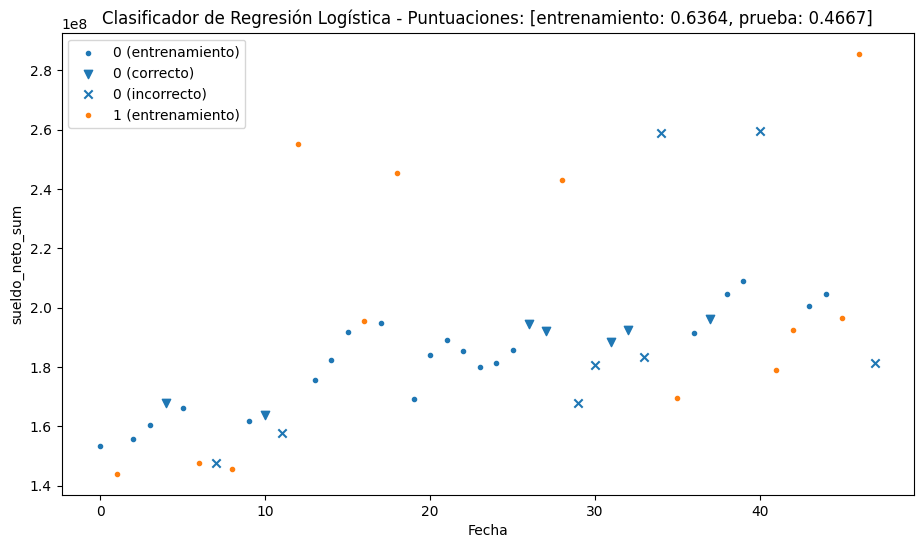

In [91]:
lr_df = detect_outlier(prepare_reg_file(), "Fecha", "sueldo_neto_sum")
train_evaluate_logistic_regression_classifier(lr_df, ["Fecha", "sueldo_neto_sum"], "outliers" )

# Evaluación del modelo de Clasificación de Regresión Logística para Facultad y Administración

## Descripción General

Se llevó a cabo un análisis utilizando modelos de regresión logística para clasificar dos categorías: 'FACULTAD' y 'ADMIN' en un conjunto de datos. Las siguientes son las etapas principales de la ejecución:

## Descripción

1. **Entrenamiento y Evaluación del Modelo para 'FACULTAD':**
- Se entrenó y evaluó un modelo de regresión logística utilizando 'promedio_pago' y 'conteo_empleados' como características y 'FACULTAD' como la variable objetivo:

```python
train_evaluate_logistic_regression_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "FACULTAD")
```

2. **Entrenamiento y Evaluación del Modelo para 'ADMIN':**
- Se entrenó y evaluó un modelo de regresión logística utilizando 'promedio_pago' y 'conteo_empleados' como características y 'ADMIN' como la variable objetivo:

```python
train_evaluate_logistic_regression_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "ADMIN")
```

## Resultados Esperados

- **Modelos de Regresión Logística:** Se generaron modelos de regresión logística para clasificar las categorías 'FACULTAD' y 'ADMIN'.
- **Evaluación del Modelo:** Se evaluaron las puntuaciones de precisión de los modelos en los conjuntos de datos de entrenamiento y prueba.

Usando LogisticRegression con {'random_state': 0, 'C': 1}


/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


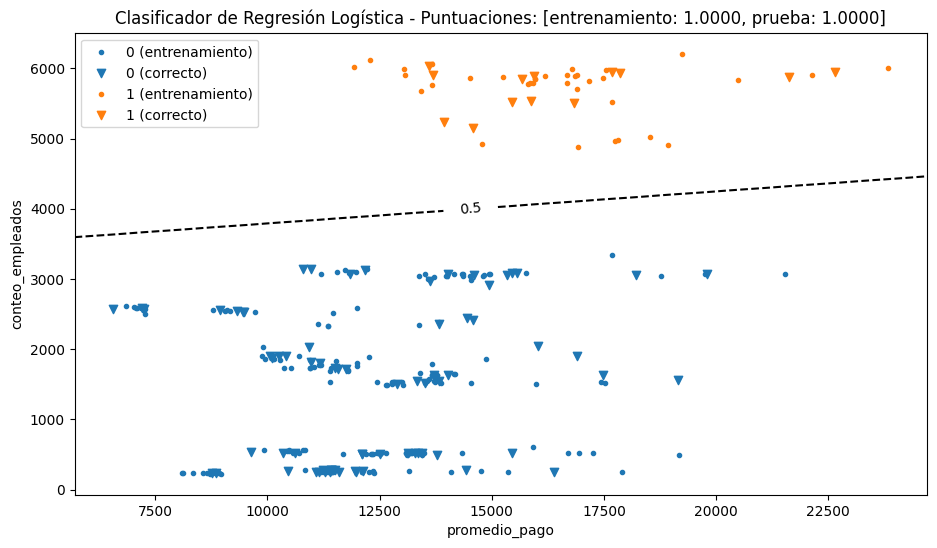

Usando LogisticRegression con {'random_state': 0, 'C': 1}


/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


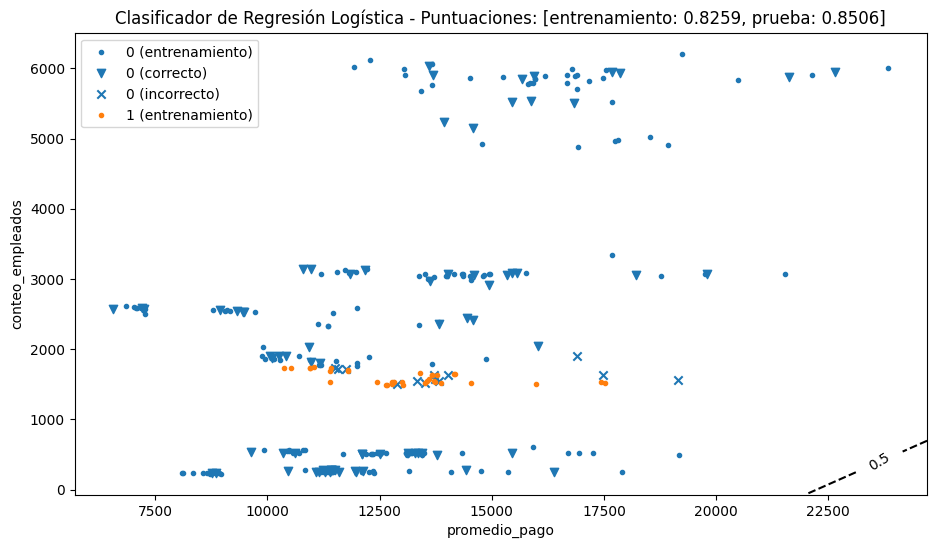

In [92]:
df = prepare_file()
df_lr_tipo = df.copy()
df_lr_tipo["FACULTAD"] = df_lr_tipo["Tipo"].apply(lambda x: 1 if x =="FACULTAD" else 0)
df_lr_tipo["ADMIN"] = df_lr_tipo["Tipo"].apply(lambda x: 1 if x =="ADMIN" else 0)

train_evaluate_logistic_regression_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "FACULTAD" )
train_evaluate_logistic_regression_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "ADMIN" )

## Regresión logística - Para todos los tipos de edificio

In [93]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

def train_evaluate_multiclass_logistic_regression(df: pd.DataFrame, x: List[str], y: str) -> None:
    """
    Crea, entrena y evalúa un modelo de regresión logística multiclase, visualizando los resultados.

    :param df: DataFrame con los datos
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    """
    # Preparar los datos
    df_fixed = df.copy()
    df_fixed['Fecha'] = transform_variable(df, "Fecha")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test_classification(df_fixed, x, y, test_size=0.3, random_state=0)

    # Entrenar el modelo
    trained_model = train_model(X_train, y_train, OneVsRestClassifier, 
                                {'estimator': LogisticRegression(random_state=0, C=1)})

    # Evaluar el modelo
    score_train = trained_model.score(X_train, y_train)
    score_test = trained_model.score(X_test, y_test)
    predict_test = trained_model.predict(X_test)

    # Crear la gráfica
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        # Filtrar datos de entrenamiento y prueba
        filter_train_df = X_train[y_train == class_]
        filter_test_df_correct = X_test[(y_test == class_) & (predict_test == class_)]
        filter_test_df_failure = X_test[(y_test != class_) & (predict_test == class_)]

        # Graficar puntos de entrenamiento
        plot_points(ax, filter_train_df[x[0]], filter_train_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (entrenamiento)"})

        # Graficar predicciones correctas
        if not filter_test_df_correct.empty:
            plot_points(ax, filter_test_df_correct[x[0]], filter_test_df_correct[x[1]], 
                        scatter_params={'marker': 'v', 'c': f"C{index}", 'label': f"{class_} (correcto)"})

        # Graficar predicciones incorrectas
        if not filter_test_df_failure.empty:
            plot_points(ax, filter_test_df_failure[x[0]], filter_test_df_failure[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (incorrecto)"})

    # Configurar la gráfica
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title(f"Clasificador de Regresión Logística Multiclase - Puntuaciones: [entrenamiento: {score_train:.4f}, prueba: {score_test:.4f}]")

    # Guardar la gráfica
    finalize_and_save(fig, ax, f'../img/clasificacion/logistic_regression/mc_lr_classifier_model_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

Usando OneVsRestClassifier con {'estimator': LogisticRegression(C=1, random_state=0)}


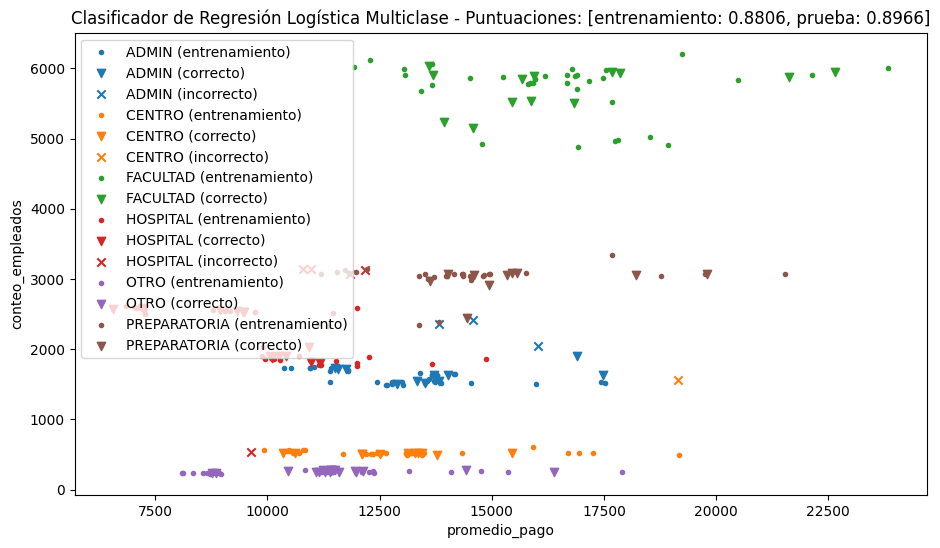

In [94]:
# Preparar los datos y ejecutar el modelo
df = prepare_file()
train_evaluate_multiclass_logistic_regression(df, ["promedio_pago", "conteo_empleados"], "Tipo")

# Support Vector Machine (SVM) - Máquina de Vectores de Soporte
---

## SVM - Evaluación del desempeño del modelo

In [95]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.svm import SVC

def train_evaluate_svm_classifier(df: pd.DataFrame, x: List[str], y: str) -> None:
    """
    Crea, entrena y evalúa un modelo de Máquinas de Vectores de Soporte (SVM), visualizando los resultados.

    :param df: DataFrame con los datos
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    """
    # Preparar los datos
    df_fixed = df.copy()
    df_fixed['Fecha'] = transform_variable(df, "Fecha")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test_classification(df_fixed, x, y, test_size=0.3, random_state=0)

    # Entrenar el modelo
    trained_model = train_model(X_train, y_train, SVC, {'random_state': 0, 'C': 1})

    # Evaluar el modelo
    score_train = trained_model.score(X_train, y_train)
    score_test = trained_model.score(X_test, y_test)
    predict_test = trained_model.predict(X_test)

    # Crear la gráfica
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        # Filtrar datos de entrenamiento y prueba
        filter_train_df = X_train[y_train == class_]
        filter_test_df_correct = X_test[(y_test == class_) & (predict_test == class_)]
        filter_test_df_failure = X_test[(y_test != class_) & (predict_test == class_)]

        # Graficar puntos de entrenamiento
        plot_points(ax, filter_train_df[x[0]], filter_train_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (entrenamiento)"})

        # Graficar predicciones correctas
        if not filter_test_df_correct.empty:
            plot_points(ax, filter_test_df_correct[x[0]], filter_test_df_correct[x[1]], 
                        scatter_params={'marker': 'v', 'c': f"C{index}", 'label': f"{class_} (correcto)"})

        # Graficar predicciones incorrectas
        if not filter_test_df_failure.empty:
            plot_points(ax, filter_test_df_failure[x[0]], filter_test_df_failure[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (incorrecto)"})

    # Configurar la gráfica
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title(f"Clasificador SVM - Puntuaciones: [entrenamiento: {score_train:.4f}, prueba: {score_test:.4f}]")

    # Guardar la gráfica
    finalize_and_save(fig, ax, f'../img/clasificacion/svm/svc_classifier_model_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

Usando SVC con {'random_state': 0, 'C': 1}


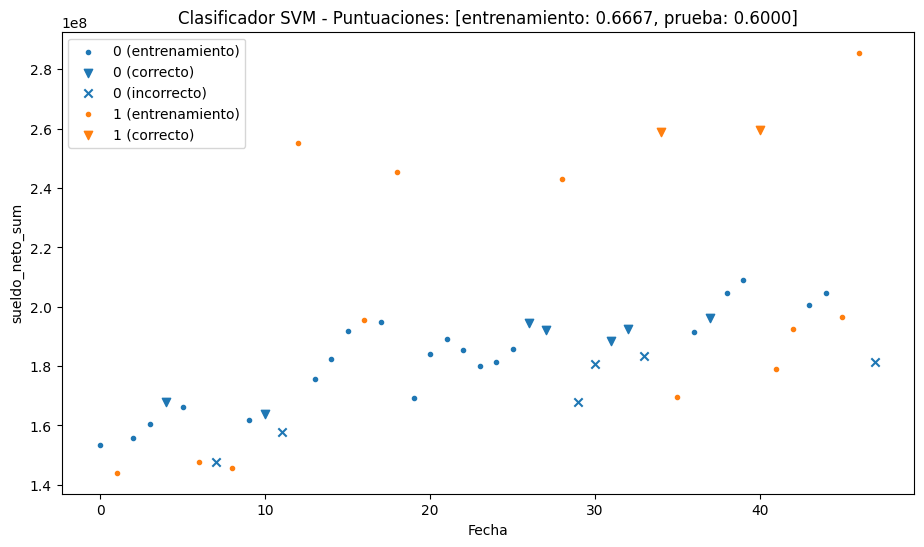

In [96]:
# Preparar los datos y ejecutar el modelo
lr_df = detect_outlier(prepare_reg_file(), "Fecha", "sueldo_neto_sum")
train_evaluate_svm_classifier(lr_df, ["Fecha", "sueldo_neto_sum"], "outliers")

## SVM - Evaluación del desempeño entre Facultay y Administrativo

Usando SVC con {'random_state': 0, 'C': 1}


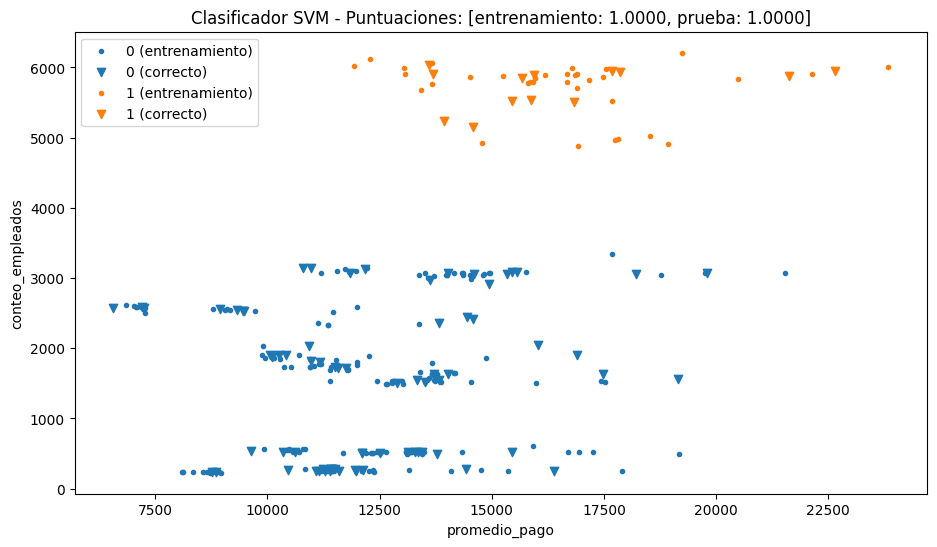

Usando SVC con {'random_state': 0, 'C': 1}


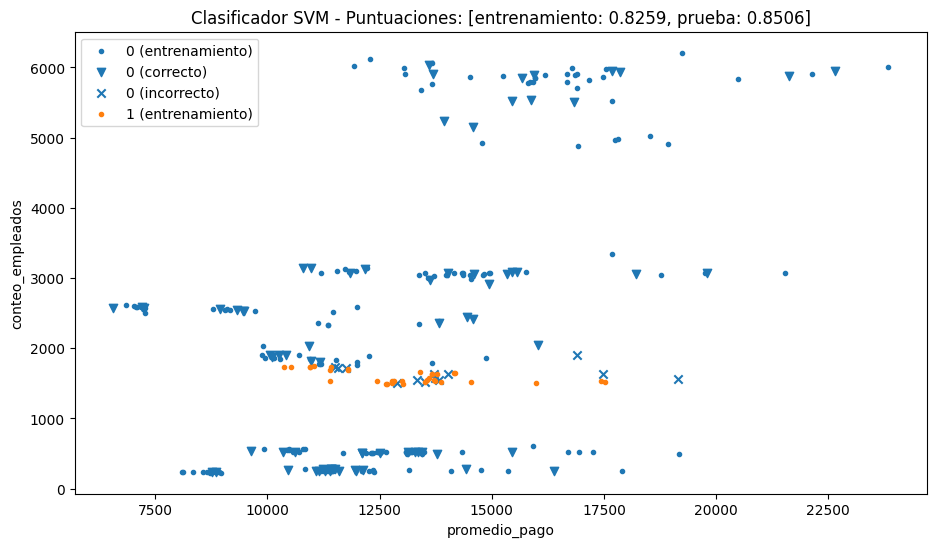

In [97]:
df = prepare_file()
df_lr_tipo = df.copy()
df_lr_tipo["FACULTAD"] = df_lr_tipo["Tipo"].apply(lambda x: 1 if x =="FACULTAD" else 0)
df_lr_tipo["ADMIN"] = df_lr_tipo["Tipo"].apply(lambda x: 1 if x =="ADMIN" else 0)
train_evaluate_svm_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "FACULTAD" )
train_evaluate_svm_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "ADMIN" )

## SVM - Para todos los tipos de edificio

In [98]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

def train_evaluate_multiclass_svm_classifier(df: pd.DataFrame, x: List[str], y: str) -> None:
    """
    Crea, entrena y evalúa un modelo de Máquinas de Vectores de Soporte (SVM) multiclase, 
    visualizando los resultados.

    :param df: DataFrame con los datos
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    """
    # Preparar los datos
    df_fixed = df.copy()
    df_fixed['Fecha'] = transform_variable(df, "Fecha")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test_classification(df_fixed, x, y, test_size=0.3, random_state=0)

    # Entrenar el modelo
    trained_model = train_model(X_train, y_train, OneVsRestClassifier, 
                                {'estimator': SVC(random_state=0, C=1)})

    # Evaluar el modelo
    score_train = trained_model.score(X_train, y_train)
    score_test = trained_model.score(X_test, y_test)
    predict_test = trained_model.predict(X_test)

    # Crear la gráfica
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        # Filtrar datos de entrenamiento y prueba
        filter_train_df = X_train[y_train == class_]
        filter_test_df_correct = X_test[(y_test == class_) & (predict_test == class_)]
        filter_test_df_failure = X_test[(y_test != class_) & (predict_test == class_)]

        # Graficar puntos de entrenamiento
        plot_points(ax, filter_train_df[x[0]], filter_train_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (entrenamiento)"})

        # Graficar predicciones correctas
        if not filter_test_df_correct.empty:
            plot_points(ax, filter_test_df_correct[x[0]], filter_test_df_correct[x[1]], 
                        scatter_params={'marker': 'v', 'c': f"C{index}", 'label': f"{class_} (correcto)"})

        # Graficar predicciones incorrectas
        if not filter_test_df_failure.empty:
            plot_points(ax, filter_test_df_failure[x[0]], filter_test_df_failure[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (incorrecto)"})

    # Configurar la gráfica
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title(f"Clasificador SVM Multiclase - Puntuaciones: [entrenamiento: {score_train:.4f}, prueba: {score_test:.4f}]")

    # Guardar la gráfica
    finalize_and_save(fig, ax, f'../img/clasificacion/svm/mc_svc_classifier_model_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

Usando OneVsRestClassifier con {'estimator': SVC(C=1, random_state=0)}


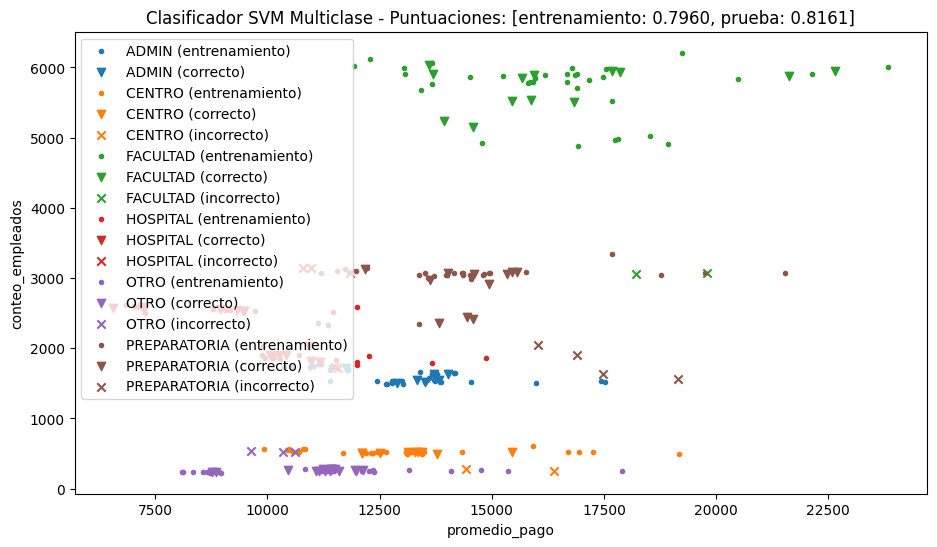

In [37]:
# Preparar los datos y ejecutar el modelo
df = prepare_file()
train_evaluate_multiclass_svm_classifier(df, ["promedio_pago", "conteo_empleados"], "Tipo")

# Decision Tree - Árbol de Decisión
---

## Decision Tree - Evaluación del desempeño del modelo

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from sklearn.tree import DecisionTreeClassifier, plot_tree

def train_evaluate_decision_tree_classifier(df: pd.DataFrame, x: List[str], y: str) -> None:
    """
    Crea, entrena y evalúa un modelo de Árbol de Decisión, visualizando los resultados
    y la estructura del árbol.

    :param df: DataFrame con los datos
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    """
    # Preparar los datos
    df_fixed = df.copy()
    df_fixed['Fecha'] = transform_variable(df, "Fecha")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test_classification(df_fixed, x, y, test_size=0.3, random_state=0)

    # Entrenar el modelo
    trained_model = train_model(X_train, y_train, DecisionTreeClassifier, 
                                {'random_state': 0, 'max_depth': 30, 'min_samples_leaf': 5})

    # Evaluar el modelo
    score_train = trained_model.score(X_train, y_train)
    score_test = trained_model.score(X_test, y_test)
    predict_test = trained_model.predict(X_test)

    # Crear la gráfica de dispersión
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        # Filtrar datos de entrenamiento y prueba
        filter_train_df = X_train[y_train == class_]
        filter_test_df_correct = X_test[(y_test == class_) & (predict_test == class_)]
        filter_test_df_failure = X_test[(y_test != class_) & (predict_test == class_)]

        # Graficar puntos de entrenamiento
        plot_points(ax, filter_train_df[x[0]], filter_train_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (entrenamiento)"})

        # Graficar predicciones correctas
        if not filter_test_df_correct.empty:
            plot_points(ax, filter_test_df_correct[x[0]], filter_test_df_correct[x[1]], 
                        scatter_params={'marker': 'v', 'c': f"C{index}", 'label': f"{class_} (correcto)"})

        # Graficar predicciones incorrectas
        if not filter_test_df_failure.empty:
            plot_points(ax, filter_test_df_failure[x[0]], filter_test_df_failure[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (incorrecto)"})

    # Configurar la gráfica de dispersión
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title(f"Clasificador de Árbol de Decisión - Puntuaciones: [entrenamiento: {score_train:.4f}, prueba: {score_test:.4f}]")

    # Guardar la gráfica de dispersión
    finalize_and_save(fig, ax, f'../img/clasificacion/decision_tree/decision_tree_classifier_model_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

    # Crear y guardar la visualización del árbol de decisión
    plt.figure(figsize=(20, 10))
    plot_tree(trained_model, feature_names=x, filled=True, rounded=True)
    plt.savefig(f"../img/clasificacion/decision_tree/decision_tree_{y}_{"_".join(x)}.png", bbox_inches="tight")
    plt.show()
    plt.close()

Usando DecisionTreeClassifier con {'random_state': 0, 'max_depth': 30, 'min_samples_leaf': 5}


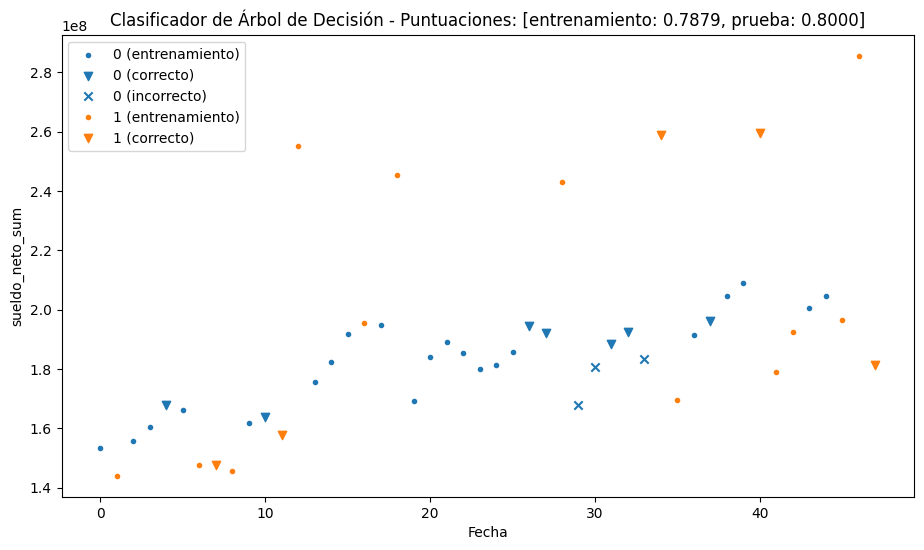

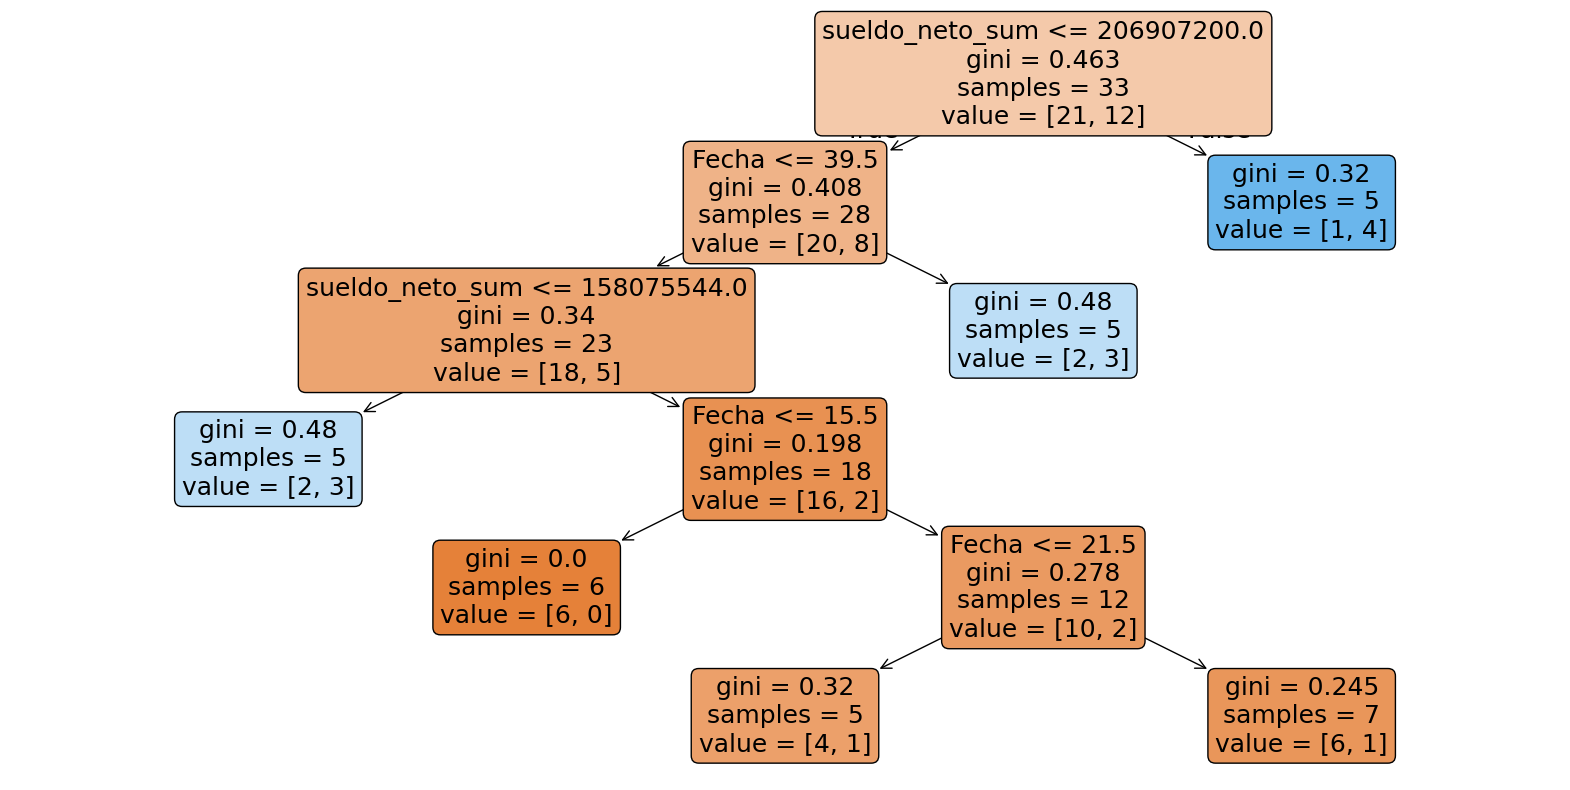

In [100]:
# Preparar los datos y ejecutar el modelo
lr_df = detect_outlier(prepare_reg_file(), "Fecha", "sueldo_neto_sum")
train_evaluate_decision_tree_classifier(lr_df, ["Fecha", "sueldo_neto_sum"], "outliers")

## Decision Tree - Evaluación del desempeño entre Facultad y Administrativo

Usando DecisionTreeClassifier con {'random_state': 0, 'max_depth': 30, 'min_samples_leaf': 5}


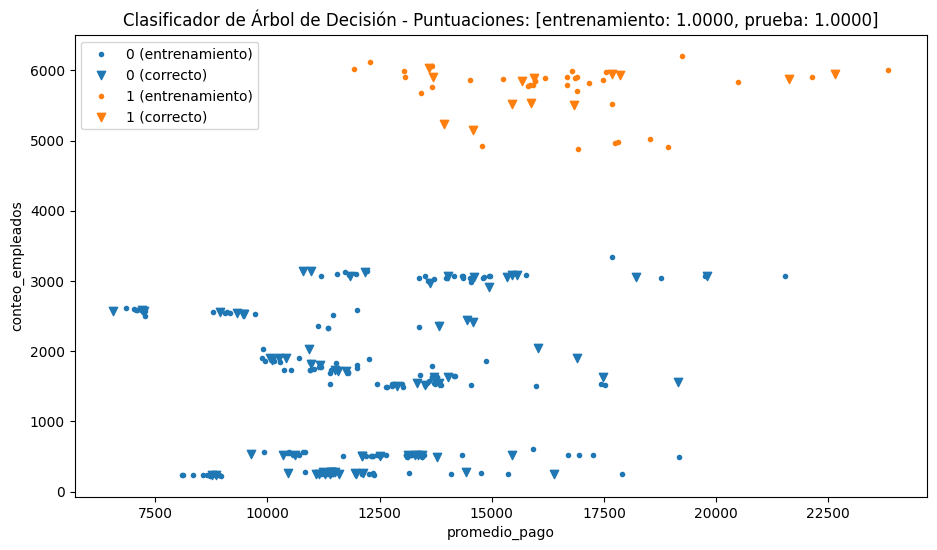

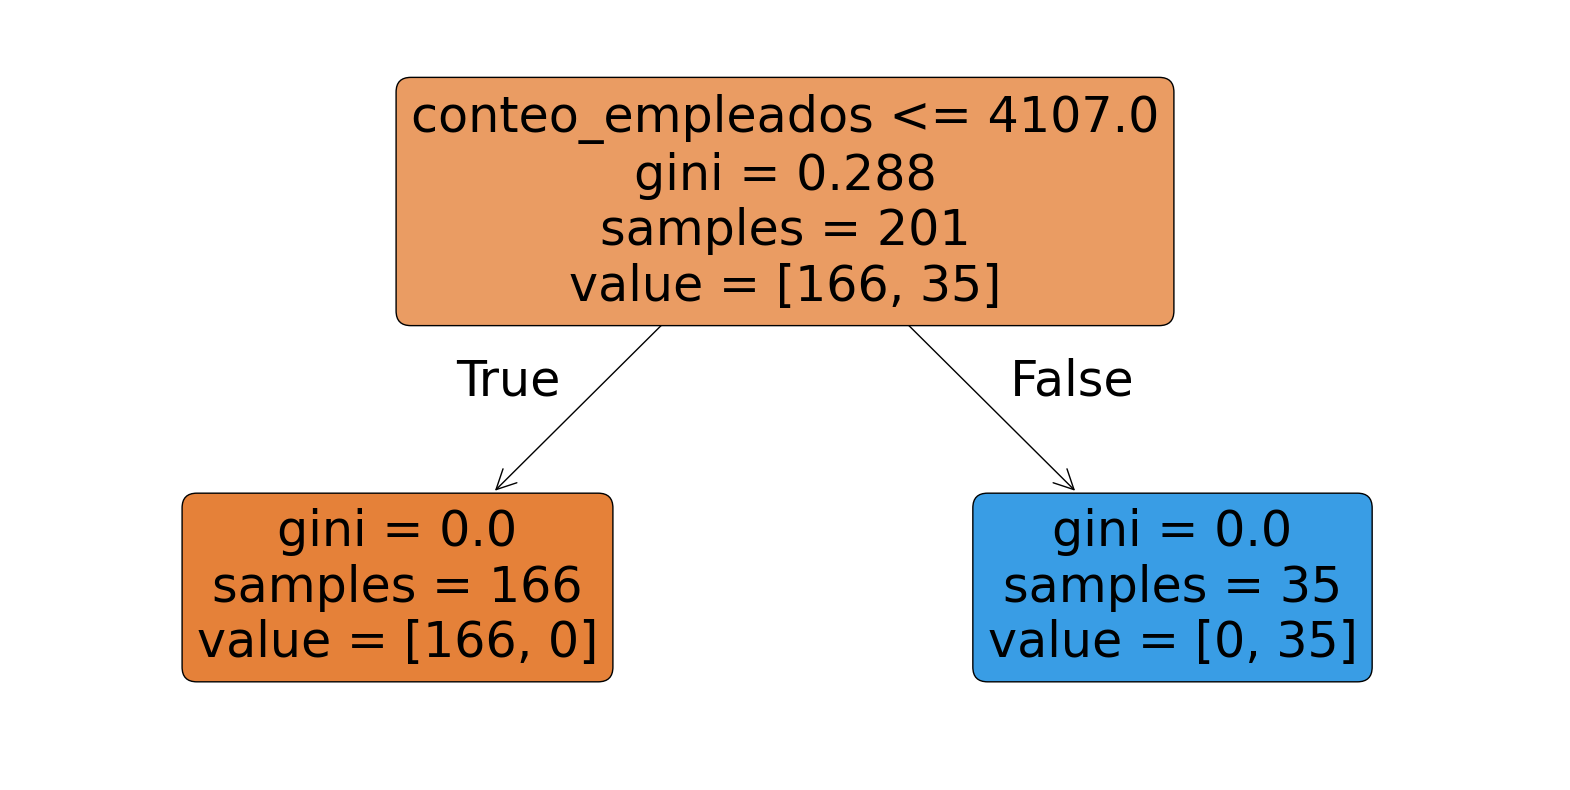

Usando DecisionTreeClassifier con {'random_state': 0, 'max_depth': 30, 'min_samples_leaf': 5}


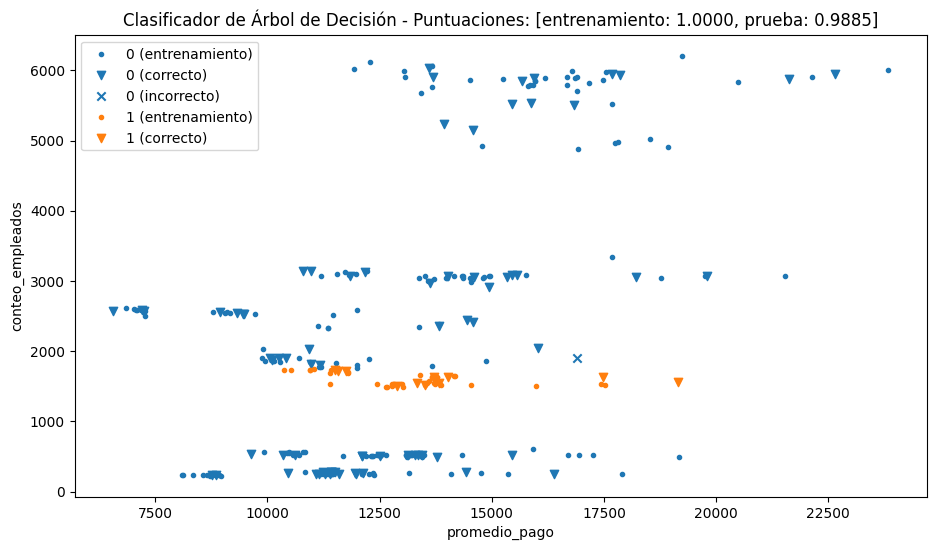

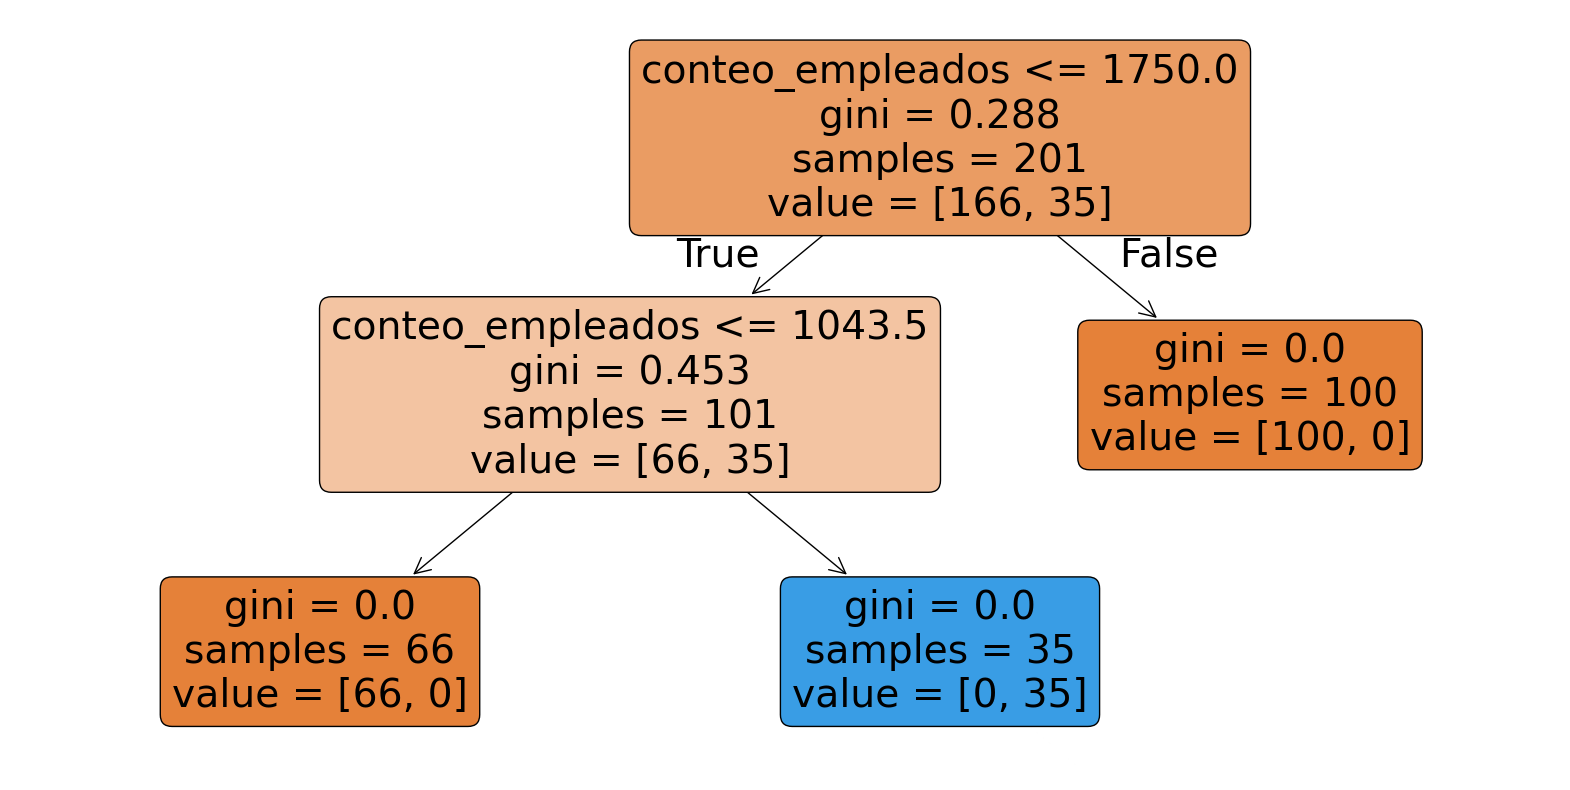

In [101]:
df = prepare_file()
df_lr_tipo = df.copy()
df_lr_tipo["FACULTAD"] = df_lr_tipo["Tipo"].apply(lambda x: 1 if x =="FACULTAD" else 0)
df_lr_tipo["ADMIN"] = df_lr_tipo["Tipo"].apply(lambda x: 1 if x =="ADMIN" else 0)
train_evaluate_decision_tree_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "FACULTAD" )
train_evaluate_decision_tree_classifier(df_lr_tipo, ["promedio_pago", "conteo_empleados"], "ADMIN" )

## Decision Tree - Para todos los tipos de edificio

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

def train_evaluate_multiclass_decision_tree_classifier(df: pd.DataFrame, x: List[str], y: str) -> None:
    """
    Crea, entrena y evalúa un modelo de Árbol de Decisión multiclase, 
    visualizando los resultados.

    :param df: DataFrame con los datos
    :param x: Lista de nombres de las columnas de características
    :param y: Nombre de la columna objetivo
    """
    # Preparar los datos
    df_fixed = df.copy()
    df_fixed['Fecha'] = transform_variable(df, "Fecha")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test_classification(df_fixed, x, y, test_size=0.3, random_state=0)

    # Entrenar el modelo
    trained_model = train_model(X_train, y_train, OneVsRestClassifier, 
                                {'estimator': DecisionTreeClassifier(random_state=0, max_depth=30, min_samples_leaf=5)})

    # Evaluar el modelo
    score_train = trained_model.score(X_train, y_train)
    score_test = trained_model.score(X_test, y_test)
    predict_test = trained_model.predict(X_test)

    # Crear la gráfica
    fig, ax = create_plot()
    categories = np.unique(df[y])

    # Graficar cada categoría
    for index, class_ in enumerate(categories):
        # Filtrar datos de entrenamiento y prueba
        filter_train_df = X_train[y_train == class_]
        filter_test_df_correct = X_test[(y_test == class_) & (predict_test == class_)]
        filter_test_df_failure = X_test[(y_test != class_) & (predict_test == class_)]

        # Graficar puntos de entrenamiento
        plot_points(ax, filter_train_df[x[0]], filter_train_df[x[1]], 
                    scatter_params={'marker': '.', 'c': f"C{index}", 'label': f"{class_} (entrenamiento)"})

        # Graficar predicciones correctas
        if not filter_test_df_correct.empty:
            plot_points(ax, filter_test_df_correct[x[0]], filter_test_df_correct[x[1]], 
                        scatter_params={'marker': 'v', 'c': f"C{index}", 'label': f"{class_} (correcto)"})

        # Graficar predicciones incorrectas
        if not filter_test_df_failure.empty:
            plot_points(ax, filter_test_df_failure[x[0]], filter_test_df_failure[x[1]], 
                        scatter_params={'marker': 'x', 'c': f"C{index}", 'label': f"{class_} (incorrecto)"})

    # Configurar la gráfica
    ax.legend(loc="upper left")
    ax.set_xlabel(x[0])
    ax.set_ylabel(x[1])
    ax.set_title(f"Clasificador de Árbol de Decisión Multiclase - Puntuaciones: [entrenamiento: {score_train:.4f}, prueba: {score_test:.4f}]")

    # Guardar la gráfica
    finalize_and_save(fig, ax, f'../img/clasificacion/decision_tree/mc_decision_tree_classifier_model_{y}_{"_".join(x)}.png', size_inches=(11, 6), rotation=0)

Usando OneVsRestClassifier con {'estimator': DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=0)}


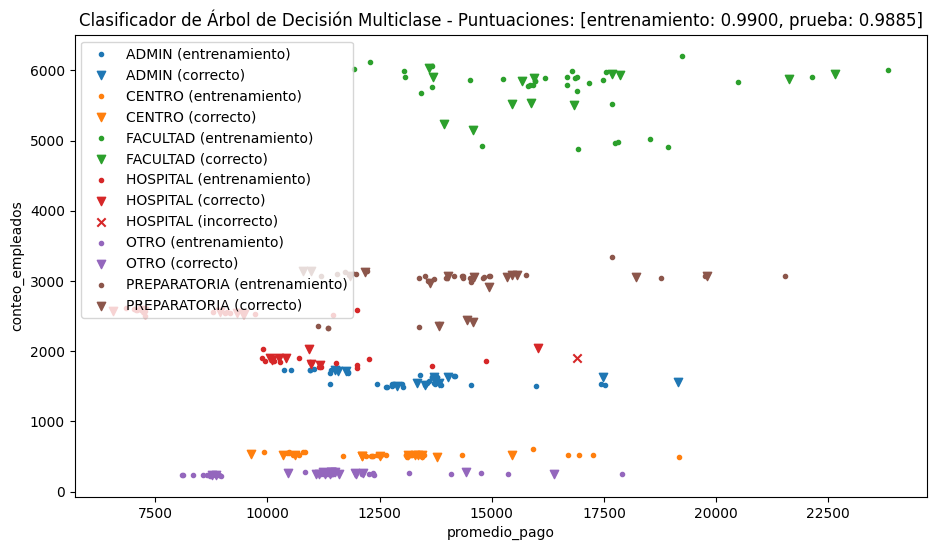

In [103]:
# Preparar los datos y ejecutar el modelo
df = prepare_file()
train_evaluate_multiclass_decision_tree_classifier(df, ["promedio_pago", "conteo_empleados"], "Tipo")